In [77]:
import random
import math
import random
import time
import itertools
from typing import List
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Predmet

In [14]:
class Item:
    def __init__(self, class_id: int, item_id: int, cubic_capacity: int, cost: int) -> None:
        """
        Trida predmetu

        Atributy:
            class_id - id tridy
            item_id - id predmetu
            cubic_capacity - objem predmetu
            cost - cena predmetu  
        """
        self.class_id = class_id
        self.item_id = item_id
        self.cubic_capacity = cubic_capacity
        self.cost = cost

    def print(self):
        print("Class-ID: %d; Item-ID: %d; Capacity: %d; Cost: %d" % (self.class_id, self.item_id, self.cubic_capacity, self.cost))

# Funkce pro vygenerovani predmetu

In [15]:
def generateItems(num_classes: int, num_items: int, cubic_capacity_func: int, cost_func) -> list[Item]:
    """
    Vygeneruje seznam predmetu

    Parametry:
        num_classes - pocet trid
        num_items - pocet predmetu ve tridach
        cubic_capacity_func - funkce pro generovani nahodneho objemu predmetu
        cost_func - funkce pro generovani nahodnehe ceny predmetu  
    
    Return:
        Seznam vsech vygenerovanych predmetu
    """
    items: list[Item] = []
    for class_id in range(1, num_classes+1):
        for item_id in range(1, num_items+1):
            items.append(Item(class_id, item_id, cubic_capacity_func(), cost_func()))
    return items

# HC algoritmus upraveny pro reseni problemu batohu

In [102]:
def knapsack_hc(items: list[Item], capacity: int, max_iter: int, class_count: int, item_count: int):
    """
    Najde nejlepsi reseni problemu s batohem za pouzit HC.

    Parametry:
        items - list predmetu
        capacity - maximalni kapacita batohu
        max_iter - maximalni pocet iteraci
        class_count - celkovy pocet trid
        item_count - pocet itemu ve tride

    Return:
        nejlepsi reseni, celkova cena nalezeneho reseni, cas reseni, history vyvoje cene (ucelovee funkce)  
    """
    start = time.time()

    history = []
    
    # inicialiace nahodneho reseni
    current_solution = [random.randint(1, item_count) for _ in range(class_count)]
    current_fitness, is_valid = evaluate_solution(current_solution, items, capacity, item_count)
    history.append(current_fitness)
    
    for _ in range(max_iter):
        # vygeneruje nahodne sousedy
        neighbor = generate_neighbor(current_solution, item_count)
        neighbor_fitness, is_valid = evaluate_solution(neighbor, items, capacity, item_count)
        
        # pokud je soused lepsi pouzije ho jako nove reseni
        if is_valid and neighbor_fitness > current_fitness:
            current_solution = neighbor
            current_fitness = neighbor_fitness
        history.append(current_fitness)
    
    # reseni
    return current_solution, current_fitness, float(time.time() - start), history

def evaluate_solution(solution: list[int], items: list[Item], capacity: int, item_count: int):
    """
    Vyhodnoti reseni. Vypocet celkove ceny vsech predmetu a overeni validity reseni.

    Parametry:
        solution - aktualni reseni
        items - list predmetu
        capacity - maximalni kapacita batohu
        item_count - pocet itemu ve tride  

    Return:
        celkova cena vsech predmetu, validita reseni
    """
    # spocita celkovou kapacitu zabranou predmeti a jejich cenu
    total_cost = 0
    total_camacity = 0
    for class_id, item_id in enumerate(solution):
        item = items[class_id * item_count + item_id - 1]   
        total_cost += item.cost
        total_camacity += item.cubic_capacity
    
    # overi, zda reseni splnuje omezeni kapacity
    is_valid = total_camacity <= capacity
    
    return total_cost, is_valid

def generate_neighbor(solution: list[int], item_count: int):   
    """
    Vygenerovani novehou sousedniho reseni

    Parametry:
        solution - aktualni reseni
        item_count - pocet itemu ve tride

    Return:
        Nove reseni  
    """ 
    neighbor = solution.copy()

    for _ in range(100):
        dim = len(solution)
        for i in range(dim):
            if random.random() > 1.0/dim:
                neighbor[i] = random.randint(1, item_count)
        # pokud je nahodne nove reseni stejne vygeneruje ho znovu
        if neighbor != solution:
            break

    return neighbor

# Brut force řešení

In [52]:
def knapsack_brutforce(items: list[Item], max_capacity: int, class_count: int, items_count: int) -> tuple([tuple[Item], float, int]):
    """
    Najde nejlepsi reseni "nejlepsi kombinace". Maximalni mozna cena & Pouze jeden predmet 
    ze tridy & Neni prekrocen maximalni objem.

    Parametry:
        items - seznam vsech predmetu
        max_capacity - maximalni kapacita batohu
        class_count - pocet trid
        items_count - pocet predmetu na jednu tridu   

    Return:
        Nejlepsi nalezna kombinace, cas potrebny pro nalezeni nejlepsiho reseni, celkovy pocet kombinaci predmetu
    """
    start = time.time()

    best_cost: int = 0
    best_combination: tuple[Item] = []

    combination_count = 0
    for i in range(1, int(len(items)/items_count)+1):
        for combination in itertools.combinations(items, i):
            combination_count +=1
            current_capacity = sum(item.cubic_capacity for item in combination)
            if current_capacity <= max_capacity:
                current_cost = sum(item.cost for item in combination)
                if current_cost > best_cost:
                    if check_classes(combination, class_count):
                        best_cost = current_cost
                        best_combination = combination


    return best_combination, float(time.time() - start), combination_count

def check_classes(combination: tuple[Item], class_count: int) -> bool:
    """
    Overi zda v kombinaci predmetu je kazdy predmet z prave jedne tridy

    Parametry:
        combination - kombinace jakymi je mozne predmety nakombinovat
        class_count - pocet trid

    Return:
        True kdyz jsou zastoupeny predmety ze vsech trid prave jednou
    """
    classes = {}
    for item in combination:
        class_id = item.class_id
        if class_id not in classes:
            classes[class_id] = 1
        else:
            return False
    return len(classes) == class_count

# Funkce pro výpis řešení

In [59]:
def printResult(best_solution: list[int], best_cost: int, items: list[Item], num_items: int, total_time: float, max_capacity: int):
    total_capacity = 0
    print("--------------------------")
    for class_id, item_id in enumerate(best_solution):
        total_capacity += items[class_id * num_items + item_id - 1].cubic_capacity
        print("Class-ID: %d; Item-ID: %d" % (class_id + 1, item_id))
    print("--------------------------")
    print("Total cost: %d" % best_cost)
    print("Total capacity: %d" % total_capacity)
    print("Total time: %f sec" % total_time)
    if total_capacity > max_capacity:
        print("!! INVALID SOLUTION !!")

# Nastaveni

In [106]:
# pocet generovanych trid
num_classes = 12  
# pocet predmetu v jedne tride
num_items = 3 
# objem predmetu (1 az 50)
cubic_capacity = lambda: random.randint(1, 51)
# cena predmetu
cost = lambda: random.randint(1, 51)
# maximalni kapacita batohu
max_capacity = 20 * num_classes
# maximalni pocet iteraci algoritmu
iterations = 20000

print("Max capacity:", max_capacity)

Max capacity: 240


# Vygenerování předmětů

In [107]:
items = generateItems(num_classes, num_items, cubic_capacity, cost)
for item in items:
    item.print()

Class-ID: 1; Item-ID: 1; Capacity: 8; Cost: 9
Class-ID: 1; Item-ID: 2; Capacity: 25; Cost: 48
Class-ID: 1; Item-ID: 3; Capacity: 13; Cost: 37
Class-ID: 2; Item-ID: 1; Capacity: 3; Cost: 21
Class-ID: 2; Item-ID: 2; Capacity: 34; Cost: 36
Class-ID: 2; Item-ID: 3; Capacity: 1; Cost: 26
Class-ID: 3; Item-ID: 1; Capacity: 23; Cost: 30
Class-ID: 3; Item-ID: 2; Capacity: 4; Cost: 5
Class-ID: 3; Item-ID: 3; Capacity: 9; Cost: 35
Class-ID: 4; Item-ID: 1; Capacity: 7; Cost: 17
Class-ID: 4; Item-ID: 2; Capacity: 42; Cost: 42
Class-ID: 4; Item-ID: 3; Capacity: 41; Cost: 24
Class-ID: 5; Item-ID: 1; Capacity: 15; Cost: 51
Class-ID: 5; Item-ID: 2; Capacity: 22; Cost: 19
Class-ID: 5; Item-ID: 3; Capacity: 16; Cost: 23
Class-ID: 6; Item-ID: 1; Capacity: 51; Cost: 17
Class-ID: 6; Item-ID: 2; Capacity: 3; Cost: 16
Class-ID: 6; Item-ID: 3; Capacity: 15; Cost: 47
Class-ID: 7; Item-ID: 1; Capacity: 8; Cost: 50
Class-ID: 7; Item-ID: 2; Capacity: 2; Cost: 15
Class-ID: 7; Item-ID: 3; Capacity: 5; Cost: 17
Clas

# Porovnání řešení HC heuristiky & brut force

In [108]:
# Spustíme algoritmus hill climbing s lokálním prohledáváním
solution, fitness, total_time, history = knapsack_hc(items, max_capacity, iterations, num_classes, num_items)
print("HC heuristic:")
printResult(solution, fitness, items, num_items, total_time, max_capacity)

HC heuristic:
--------------------------
Class-ID: 1; Item-ID: 2
Class-ID: 2; Item-ID: 1
Class-ID: 3; Item-ID: 3
Class-ID: 4; Item-ID: 2
Class-ID: 5; Item-ID: 1
Class-ID: 6; Item-ID: 3
Class-ID: 7; Item-ID: 1
Class-ID: 8; Item-ID: 3
Class-ID: 9; Item-ID: 2
Class-ID: 10; Item-ID: 3
Class-ID: 11; Item-ID: 3
Class-ID: 12; Item-ID: 3
--------------------------
Total cost: 478
Total capacity: 228
Total time: 0.353719 sec


In [110]:
solution_2, total_time_2, _ = knapsack_brutforce(items, max_capacity, num_classes, num_items)
print("Brutforce:")
printResult([item.item_id for item in solution_2], fitness, items, num_items, total_time_2, max_capacity)

Brutforce:
--------------------------
Class-ID: 1; Item-ID: 2
Class-ID: 2; Item-ID: 3
Class-ID: 3; Item-ID: 3
Class-ID: 4; Item-ID: 2
Class-ID: 5; Item-ID: 1
Class-ID: 6; Item-ID: 3
Class-ID: 7; Item-ID: 1
Class-ID: 8; Item-ID: 3
Class-ID: 9; Item-ID: 2
Class-ID: 10; Item-ID: 2
Class-ID: 11; Item-ID: 3
Class-ID: 12; Item-ID: 3
--------------------------
Total cost: 478
Total capacity: 236
Total time: 2669.269345 sec


# Konvergenční graf pro HC heuristiku

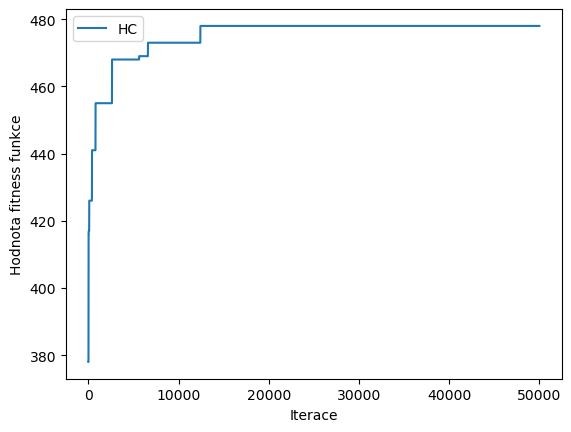

In [111]:
# zobrazeni grafu
plt.plot(np.linspace(1, len(history), len(history)), history)
plt.xlabel('Iterace')
plt.ylabel('Hodnota fitness funkce')
plt.legend(['HC'])
plt.show()

# Závěr
Z výsledku je vidět, že použití HC heuristiky pro řešení problému s batohem mnohonásobně ušetří čas potřebný k nalezení nejlepšího řešení problému. HC heuristika řešení problému nalezena během několika sekund, zatímco metodě brut force, kterou jsem implementoval v minulém úkolu, trvalo nalezení řešení přibližně 44 minut. Čas byl přiliš výsoký a dal byl se snižit paralelizací procesu, v mém připadě 16x, ale i po takové optimalizaci by čas byl stále výrazneji pomalejší. Brut force je jednoducha metoda řešení problému a podle toho odpovídají výsledky, v tomto případě vysoká časová náročnost. Hodnota účelové funkce byla u obou algoritmu shodná.